In [94]:
import pyspark as ps    # for the pyspark suite
from pyspark.sql.functions import *
from matplotlib.pyplot import *
import pandas as pd

In [2]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('capstone')
         .getOrCreate()
        )
sc = spark.sparkContext

In [3]:
spark

In [5]:
spark.sql("Create Database Imdb").show()

++
||
++
++



In [6]:
df_movie_raw = spark.read.csv('data/title.basics.tsv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep="\t",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?

In [7]:
df_movie_raw.createOrReplaceTempView('Imdb_All')


In [8]:
spark.sql("Desc Imdb_All").show()

+--------------+---------+-------+
|      col_name|data_type|comment|
+--------------+---------+-------+
|        tconst|   string|   null|
|     titleType|   string|   null|
|  primaryTitle|   string|   null|
| originalTitle|   string|   null|
|       isAdult|      int|   null|
|     startYear|   string|   null|
|       endYear|   string|   null|
|runtimeMinutes|   string|   null|
|        genres|   string|   null|
+--------------+---------+-------+



In [9]:
# Type of titles in Imdb
spark.sql("Select distinct(m.titleType) from Imdb_All m").show()

+------------+
|   titleType|
+------------+
|    tvSeries|
|tvMiniSeries|
|     tvMovie|
|   tvEpisode|
|       movie|
|   tvSpecial|
|       video|
|   videoGame|
|     tvShort|
|       short|
+------------+



In [10]:
df_ratings_raw = spark.read.csv('data/title.ratings.tsv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep="\t",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?

In [11]:
df_ratings_raw.createOrReplaceTempView('Ratings')

In [12]:
spark.sql("Desc Ratings").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       tconst|   string|   null|
|averageRating|   double|   null|
|     numVotes|      int|   null|
+-------------+---------+-------+



In [14]:
df_principal_crew_raw = spark.read.csv('data/title.principals.tsv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep="\t",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?

In [15]:
df_principal_crew_raw.createOrReplaceTempView('Principal_Crew')

In [16]:
spark.sql("Desc Principal_Crew").show()

+----------+---------+-------+
|  col_name|data_type|comment|
+----------+---------+-------+
|    tconst|   string|   null|
|  ordering|      int|   null|
|    nconst|   string|   null|
|  category|   string|   null|
|       job|   string|   null|
|characters|   string|   null|
+----------+---------+-------+



In [17]:
spark.sql("Select distinct(category) from Principal_Crew").show()

+-------------------+
|           category|
+-------------------+
|            actress|
|           producer|
|             writer|
|           composer|
|           director|
|               self|
|              actor|
|             editor|
|    cinematographer|
|      archive_sound|
|production_designer|
|    archive_footage|
+-------------------+



In [18]:
df_crew_names = spark.read.csv('data/name.basics.tsv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep="\t",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?

In [19]:
df_crew_names.createOrReplaceTempView('Crew_names')


In [20]:
spark.sql("Desc Crew_names").show()

+-----------------+---------+-------+
|         col_name|data_type|comment|
+-----------------+---------+-------+
|           nconst|   string|   null|
|      primaryName|   string|   null|
|        birthYear|   string|   null|
|        deathYear|   string|   null|
|primaryProfession|   string|   null|
|   knownForTitles|   string|   null|
+-----------------+---------+-------+



In [25]:
spark.sql("Show tables").show()

+--------+--------------+-----------+
|database|     tableName|isTemporary|
+--------+--------------+-----------+
|        |    crew_names|       true|
|        |      imdb_all|       true|
|        |        movies|       true|
|        |principal_crew|       true|
|        |       ratings|       true|
+--------+--------------+-----------+



In [126]:
# Filtering to movie and tvMovie type
df_movies = spark.sql("select * from Imdb_All m where m.titleType in ('tvMovie','movie')")

In [23]:
df_movies.createOrReplaceTempView('Movies')

In [26]:
#Filtering crew to writers only, writers have books the movie was adapted from
df_writers = spark.sql("Select tconst, nconst, category, job from Principal_Crew where category = 'writer'")

In [27]:
df_writers.createOrReplaceTempView('Writers')

In [28]:
spark.sql("Desc Writers").show()

+--------+---------+-------+
|col_name|data_type|comment|
+--------+---------+-------+
|  tconst|   string|   null|
|  nconst|   string|   null|
|category|   string|   null|
|     job|   string|   null|
+--------+---------+-------+



In [29]:
spark.sql("Desc Movies").show()

+--------------+---------+-------+
|      col_name|data_type|comment|
+--------------+---------+-------+
|        tconst|   string|   null|
|     titleType|   string|   null|
|  primaryTitle|   string|   null|
| originalTitle|   string|   null|
|       isAdult|      int|   null|
|     startYear|   string|   null|
|       endYear|   string|   null|
|runtimeMinutes|   string|   null|
|        genres|   string|   null|
+--------------+---------+-------+



In [30]:
spark.sql("Desc ratings").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       tconst|   string|   null|
|averageRating|   double|   null|
|     numVotes|      int|   null|
+-------------+---------+-------+



In [31]:
# Joining movies and ratings table
df_movies_ratings = spark.sql("select m.tconst as movie_id, m.titleType as title_type, m.primaryTitle as primary_title, m.originalTitle as original_title, m.startYear as year, m.runtimeMinutes as runtime_mins, m.genres as genres, r.averageRating as avg_ratings, r.numVotes as votes from Movies m inner join ratings r on m.tconst = r.tconst")

In [33]:
df_movies_ratings.createOrReplaceTempView('Movies_and_Ratings')

In [34]:
spark.sql("Desc Movies_and_Ratings").show()

+--------------+---------+-------+
|      col_name|data_type|comment|
+--------------+---------+-------+
|      movie_id|   string|   null|
|    title_type|   string|   null|
| primary_title|   string|   null|
|original_title|   string|   null|
|          year|   string|   null|
|  runtime_mins|   string|   null|
|        genres|   string|   null|
|   avg_ratings|   double|   null|
|         votes|      int|   null|
+--------------+---------+-------+



In [35]:
# Joining writers and crew info table
df_writer_info = spark.sql("select w.tconst as movie_id, w.nconst as crew_id, w.category as category, c.primaryName as name, c.birthYear as birth_year, c.primaryProfession as profession, w.job as job_desc from Writers w inner join crew_names c on w.nconst = c.nconst")

In [36]:
df_writer_info.printSchema()

root
 |-- movie_id: string (nullable = true)
 |-- crew_id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- name: string (nullable = true)
 |-- birth_year: string (nullable = true)
 |-- profession: string (nullable = true)
 |-- job_desc: string (nullable = true)



In [37]:
df_writer_info.createOrReplaceTempView("Writer_Info")

In [38]:
spark.sql('Show tables').show()

+--------+------------------+-----------+
|database|         tableName|isTemporary|
+--------+------------------+-----------+
|        |        crew_names|       true|
|        |          imdb_all|       true|
|        |            movies|       true|
|        |movies_and_ratings|       true|
|        |    principal_crew|       true|
|        |           ratings|       true|
|        |       writer_info|       true|
|        |           writers|       true|
+--------+------------------+-----------+



In [39]:
spark.sql("select max(year), min(year) from movies_and_ratings where year > 0").show()

+---------+---------+
|max(year)|min(year)|
+---------+---------+
|     2020|     1894|
+---------+---------+



In [40]:
spark.sql("Desc movies_and_ratings").show()

+--------------+---------+-------+
|      col_name|data_type|comment|
+--------------+---------+-------+
|      movie_id|   string|   null|
|    title_type|   string|   null|
| primary_title|   string|   null|
|original_title|   string|   null|
|          year|   string|   null|
|  runtime_mins|   string|   null|
|        genres|   string|   null|
|   avg_ratings|   double|   null|
|         votes|      int|   null|
+--------------+---------+-------+



In [132]:
spark.sql("Desc writer_info").show()

+----------+---------+-------+
|  col_name|data_type|comment|
+----------+---------+-------+
|  movie_id|   string|   null|
|   crew_id|   string|   null|
|  category|   string|   null|
|      name|   string|   null|
|birth_year|   string|   null|
|profession|   string|   null|
|  job_desc|   string|   null|
+----------+---------+-------+



In [137]:
spark.sql("select max(votes), min(votes) from movies_and_ratings").show()

+----------+----------+
|max(votes)|min(votes)|
+----------+----------+
|   2210915|         5|
+----------+----------+



In [147]:
spark.sql("select * from movies_and_ratings where movie_id = 'tt0810922'").show()

+---------+----------+--------------------+--------------------+----+------------+--------------------+-----------+-----+
| movie_id|title_type|       primary_title|      original_title|year|runtime_mins|              genres|avg_ratings|votes|
+---------+----------+--------------------+--------------------+----+------------+--------------------+-----------+-----+
|tt0810922|     movie|Take Me Home Tonight|Take Me Home Tonight|2011|          97|Comedy,Drama,Romance|        6.3|50088|
+---------+----------+--------------------+--------------------+----+------------+--------------------+-----------+-----+



In [189]:
# combining movies+ratings and writer+crew info
df_movies_writers = spark.sql("select m.movie_id, m.primary_title, m.year, m.genres, w.crew_id, w.name, w.profession, m.avg_ratings, m.votes, w.job_desc from movies_and_ratings m inner join writer_info w on m.movie_id = w.movie_id and m.year >=2005 and m.year <= 2020 and m.votes >= 100")

In [190]:
# Total number of movies gathered from year 2005 to 2020 with more than 100 votes(review count)
df_movies_writers.count()

52779

In [191]:
df_movies_writers.createOrReplaceTempView('movies_and_writers')

In [192]:
spark.sql("desc movies_and_writers").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|     movie_id|   string|   null|
|primary_title|   string|   null|
|         year|   string|   null|
|       genres|   string|   null|
|      crew_id|   string|   null|
|         name|   string|   null|
|   profession|   string|   null|
|  avg_ratings|   double|   null|
|        votes|      int|   null|
|     job_desc|   string|   null|
+-------------+---------+-------+



In [158]:
spark.sql("select distinct(job_desc) from movies_and_writers").show(500, False)

+--------------------------------------------------------------------------------------------------------------------+
|job_desc                                                                                                            |
+--------------------------------------------------------------------------------------------------------------------+
|based on the comic book "The Secret Service" by                                                                     |
|short story "The Link"                                                                                              |
|poetry                                                                                                              |
|original story and screenplay by                                                                                    |
|article "On Seeing a Sex Surrogate"                                                                                 |
|novel "Tony and Susan"                         

In [159]:
spark.sql("select count(distinct(job_desc)) from movies_and_writers").show(500, False)

+------------------------+
|count(DISTINCT job_desc)|
+------------------------+
|2085                    |
+------------------------+



In [161]:
spark.sql("select count(distinct(job_desc)) from movies_and_writers where job_desc like 'novel %' OR job_desc like 'book %' or job_desc like 'based on %'").show(500, False)

+------------------------+
|count(DISTINCT job_desc)|
+------------------------+
|805                     |
+------------------------+



In [162]:
spark.sql("select movie_id, primary_title, crew_id, name, profession, avg_ratings, votes from movies_and_writers where job_desc like 'novel %' OR job_desc like 'book %' or job_desc like 'based on %'").show(500, False)

+----------+----------------------------------------------------------------------+----------+-----------------------------+------------------------------------------------+-----------+------+
|movie_id  |primary_title                                                         |crew_id   |name                         |profession                                      |avg_ratings|votes |
+----------+----------------------------------------------------------------------+----------+-----------------------------+------------------------------------------------+-----------+------+
|tt2802144 |Kingsman: The Secret Service                                          |nm2092839 |Mark Millar                  |writer,producer,actor                           |7.7        |567762|
|tt2802144 |Kingsman: The Secret Service                                          |nm1733301 |Dave Gibbons                 |writer,producer,art_department                  |7.7        |567762|
|tt3446852 |Bodybuilder            

In [163]:
spark.sql("select * from movies_and_writers where job_desc like 'novel %' OR job_desc like 'book %' or job_desc like 'based on %'").show(500, False)

+------------------------+
|count(DISTINCT movie_id)|
+------------------------+
|1625                    |
+------------------------+



In [193]:
# Filtering movies which has 'based on'/'book'/'novel' in the writer's job desc
df_based_on_books = spark.sql("select * from movies_and_writers where job_desc like 'novel %' OR job_desc like 'book %' or job_desc like 'based on %'")

In [202]:
df_based_on_books.count()

2444

In [196]:
df_based_on_books.coalesce(1).write.csv("output.csv")

In [203]:
df_cleaned_date = spark.read.csv('output_new.csv',
                         header=False,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         inferSchema=True)

In [204]:
df_cleaned_date.count()

2444

In [205]:
from pyspark.sql.types import *

schema = StructType( [
    StructField('movie_id',     StringType(), True),
    StructField('primary_title',   StringType(),  True),
    StructField('year',   StringType(),  True),
    StructField('genres',   StringType(),  True),
    StructField('crew_id',  StringType(), True),
    StructField('name',  StringType(),  True),
    StructField('profession',StringType(), True),
    StructField('avg_ratings', DoubleType(),   True), 
    StructField('votes', IntegerType(),   True),
    StructField('job_desc', StringType(),   True) ] )

In [206]:
df_cleaned_data = spark.read.csv('output_new.csv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         schema=schema)

In [207]:
df_cleaned_data.count()

2443

In [208]:
df_cleaned_data.createOrReplaceTempView("clean_books_movie")

In [215]:
df_book_list = spark.sql("Select (case when (locate(':', job_desc,instr(job_desc, ':') +1) - instr(job_desc, ':')) > 2 then substring(job_desc, instr(job_desc, ':') + 1, locate(':', job_desc,instr(job_desc, ':') +1) - instr(job_desc, ':') - 1) else primary_title end) as book_name from clean_books_movie").toPandas()

In [209]:
spark.sql("Select movie_id, avg_ratings, votes, name,  (case when (locate(':', job_desc,instr(job_desc, ':') +1) - instr(job_desc, ':')) > 2 then substring(job_desc, instr(job_desc, ':') + 1, locate(':', job_desc,instr(job_desc, ':') +1) - instr(job_desc, ':') - 1) else primary_title end) as book_name from clean_books_movie").coalesce(1).write.csv("books")

In [ ]:
# Goodreads data for 100 books

In [213]:
df_goodread_data = spark.read.csv('goodread_books_latest.csv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         inferSchema=True)

In [214]:
df_goodread_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- isbn: string (nullable = true)
 |-- num_pages: integer (nullable = true)
 |-- ratings_count: integer (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- text_reviews_count: integer (nullable = true)
 |-- movie_ref: string (nullable = true)



In [215]:
df_goodread_data.createOrReplaceTempView("goodreads")

In [216]:
df_distinct = spark.sql("select m.movie_id, m.primary_title, m.year, m.genres, m.avg_ratings, m.votes from movies_and_ratings m where m.movie_id in (select distinct(movie_id) from movies_and_writers where job_desc like 'novel %' OR job_desc like 'book %' or job_desc like 'based on %')")
df_distinct.createOrReplaceTempView("adapated_movies")

In [217]:
spark.sql("Desc goodreads").show()

+------------------+---------+-------+
|          col_name|data_type|comment|
+------------------+---------+-------+
|                id|      int|   null|
|             title|   string|   null|
|              isbn|   string|   null|
|         num_pages|      int|   null|
|     ratings_count|      int|   null|
|    average_rating|   double|   null|
|text_reviews_count|      int|   null|
|         movie_ref|   string|   null|
+------------------+---------+-------+



In [142]:
spark.sql("desc adapated_movies").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|     movie_id|   string|   null|
|primary_title|   string|   null|
|         year|   string|   null|
|       genres|   string|   null|
|  avg_ratings|   double|   null|
|        votes|      int|   null|
+-------------+---------+-------+



In [239]:
spark.sql("select distinct(genres) from adapated_movies").show(50,False)

+------------------------+
|genres                  |
+------------------------+
|Action,Adventure,Fantasy|
|Comedy,Sport            |
|Adventure,Family,Fantasy|
|Fantasy,Horror,War      |
|Fantasy,Mystery,Thriller|
|Documentary,Sport       |
|Action,Animation,Sci-Fi |
|Animation,Comedy        |
|Comedy,Family           |
|Action,Comedy           |
|Crime                   |
|Drama,Mystery           |
|Adventure,Comedy,Drama  |
|Romance                 |
|Drama,Music,Musical     |
|Drama,Romance,Sport     |
|Comedy,Drama,Mystery    |
|Action,Drama,Sci-Fi     |
|Thriller                |
|Comedy,Drama,History    |
|Action,Biography,Crime  |
|Drama,History,Horror    |
|Mystery,Thriller        |
|Action,Drama,Mystery    |
|Sci-Fi,Thriller         |
|Drama,Mystery,Romance   |
|Mystery,Sci-Fi          |
|Crime,Drama,Thriller    |
|Action,Drama,Sport      |
|Crime,Mystery           |
|Crime,Drama,Fantasy     |
|Drama,Mystery,War       |
|Animation,Comedy,Drama  |
|Comedy,Fantasy,Horror   |
|

In [218]:
pd_movie_book = spark.sql("select m.primary_title as Movie, g.title as Book, m.year as Movie_year, m.genres as Genres, m.avg_ratings as Movie_ratings, g.average_rating as Book_ratings, m.votes as Movie_review_count, g.ratings_count as Book_rating_ount, g.text_reviews_count as Book_review_count from adapated_movies m inner join goodreads g on m.movie_id = g.movie_ref").toPandas()

In [219]:
pd_movie_book["normalize_movie_ratings"] = 0.44 * (pd_movie_book["Movie_ratings"] - 10) + 5

In [220]:
pd_movie_book.count()

Movie                      2105
Book                       2105
Movie_year                 2105
Genres                     2105
Movie_ratings              2105
Book_ratings               2105
Movie_review_count         2105
Book_rating_ount           2105
Book_review_count          2105
normalize_movie_ratings    2105
dtype: int64

In [221]:
pd_gb_count = pd_movie_book.groupby('Movie_year').count()[['Movie']]

In [222]:
pd_gb_ratings = pd_movie_book.groupby('Movie_year').mean()[['normalize_movie_ratings','Book_ratings']]

In [289]:
new = pd_movie_book["Genres"].str.split(",", n = 1, expand = True) 
pd_movie_book["Genre"] = new[0]
list(pd_movie_book["Genre"].unique())

[u'Adventure',
 u'Action',
 u'Drama',
 u'Comedy',
 u'Crime',
 u'Thriller',
 u'Romance',
 u'Horror',
 u'Mystery',
 u'Biography',
 u'Family',
 u'Fantasy',
 u'Animation',
 u'Documentary',
 u'Sci-Fi',
 u'Musical',
 u'History',
 u'Music',
 u'War']

In [223]:
pd_gb_ratings['normalize_movie_ratings'].mean(), pd_gb_ratings['normalize_movie_ratings'].std()

(3.3279802398597207, 0.08381720938442874)

In [224]:
pd_gb_ratings['Book_ratings'].mean(), pd_gb_ratings['Book_ratings'].std()

(3.6779617274847416, 0.06325541381268811)

In [225]:
pd_movie_book.groupby('Movie_year').mean()[['Movie_review_count','Book_rating_ount']]

,Movie_review_count,Book_rating_ount
Movie_year,,
2005,30562.802198,44640.450549
2006,18941.915888,31844.523364
2007,35716.153846,37264.987179
2008,41053.658537,86007.134146
2009,38238.500000,43975.202128
2010,44770.759259,56050.611111
2011,49090.508197,74406.622951
2012,64386.108527,88818.612403
2013,64760.512195,92932.030488


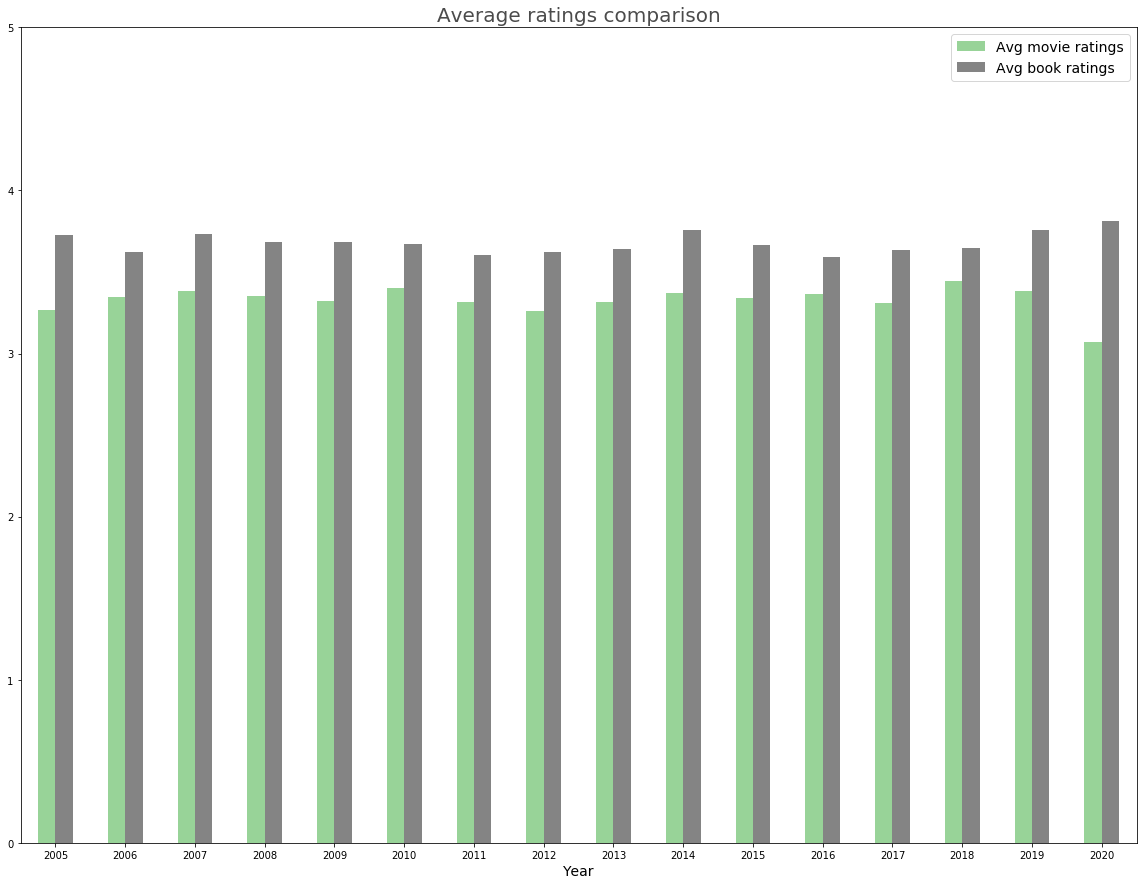

In [324]:
fig, ax = subplots()
pd_gb_ratings.plot.bar(rot = 0, ax=ax, figsize = (20, 15), colormap = 'Accent', alpha = 0.8)
ax.set_title('Average ratings comparison',fontsize=20, color= 'k', alpha = 0.7)
ax.set_xlabel("Year",fontsize=14)
ax.set_ylim(0.0, 5.0)
ax.legend(['Avg movie ratings', 'Avg book ratings'], fontsize=14);

In [228]:
pd_movies = spark.sql("select movie_id, year from movies_and_ratings where year >= 2005 and year <=2020").toPandas()

In [229]:
pd_gp_movies = pd_movies.groupby('year').count()

In [230]:
pd_gp_movies['movie_id'] = pd_gp_movies['movie_id'] / 12

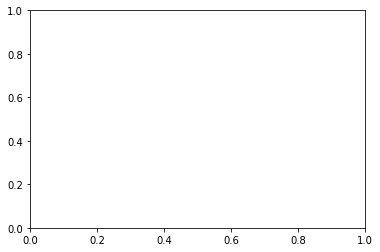

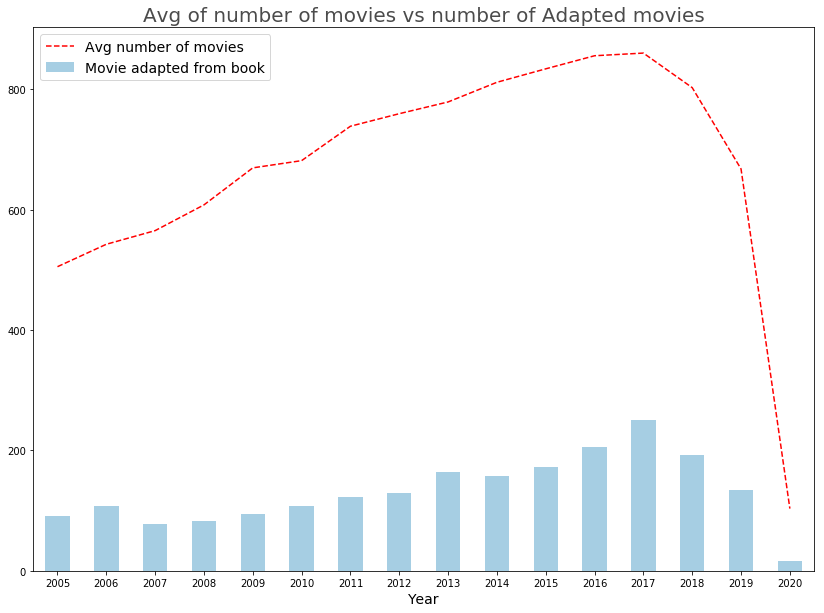

In [326]:
fig, ax = subplots()
ax = pd_gp_movies.plot(kind='line',linestyle='--',c = 'red')
pd_gb_count.plot.bar(rot = 0,ax=ax, figsize = (14, 10), colormap='Paired')
ax.set_title('Avg of number of movies vs number of Adapted movies',fontsize=20, color= 'k', alpha = 0.7)
ax.set_xlabel("Year",fontsize=14)
ax.legend(['Avg number of movies','Movie adapted from book'], fontsize=14)

In [173]:
df_test =spark.sql("select tconst, startYear from movies where startYear >= 2010 and startYear <=2020").toPandas()

In [175]:
df_gb_test = df_test.groupby('startYear').count()

In [176]:
df_gb_test

,tconst
startYear,
2010,15005
2011,16288
2012,17370
2013,18070
2014,19099
2015,20131
2016,21402
2017,21435
2018,20481


In [290]:
pd_gb_count_genres = pd_movie_book.groupby(['Movie_year','Genre']).count()[['Movie']]

Text(0.5,0,'Year')

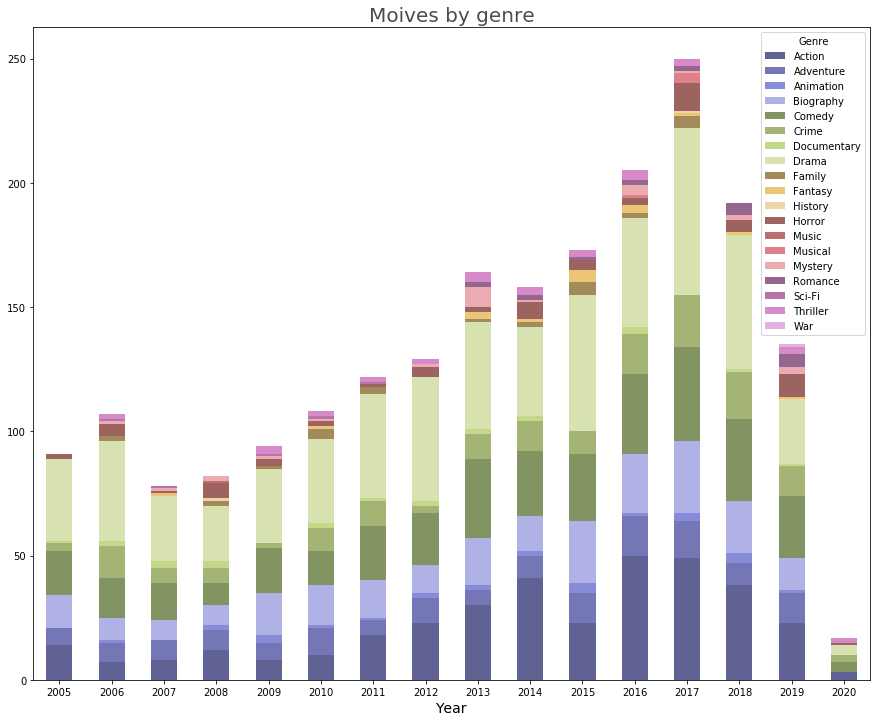

In [327]:
pivot_df = pd_gb_count_genres.reset_index().pivot(index='Movie_year', columns='Genre', values='Movie')
pivot_df.fillna(0)
fig, ax = subplots()
pivot_df.loc[:,['Action','Adventure', 'Animation','Biography','Comedy','Crime','Documentary','Drama','Family','Fantasy','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Thriller','War']].plot.bar(rot = 0,stacked=True,colormap='tab20b', figsize=(15,12), ax=ax, alpha = 0.8)
ax.set_title('Moives by enre',fontsize=20, color= 'k', alpha = 0.7)
ax.set_xlabel("Year",fontsize=14)
